## Machine Learning Model Pipeline: Wrapping up for Deployment


Here, we will summarise, the key pieces of code, that we need to take forward, for this particular project, to put our model in production.



In [12]:
# to handle datasets
import pandas as pd
import numpy as np

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to build the models
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

# to evaluate the models
from sklearn.metrics import mean_squared_error
from math import sqrt

# to persist the model and the scaler
from sklearn.externals import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

### Setting the seed


Important note **Always set the seeds**.

Load Libraries

In [13]:
SEED = 123

## Load data

We need the training data to train our model in the production environment. 

In [5]:
# load dataset
data_in = pd.read_csv('../../data/interim/raw_useful_ftrs.csv')
data = data_in.dropna()
print(data.shape)
data.head()

C:\Users\josal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(629364, 10)


,code_commune,code_postal,latitude,longitude,nature_culture,nombre_pieces_principales,surface_reelle_bati,surface_terrain,type_local,valeur_fonciere
0,1053,1000.0,46.198840,5.209562,aucune,1.0,20.0,0.0,Appartement,37220.0
1,1314,1160.0,45.999566,5.282104,sols,4.0,90.0,940.0,Maison,209000.0
2,1350,1370.0,46.293278,5.299929,sols,5.0,101.0,490.0,Maison,134900.0
3,1024,1340.0,46.269978,5.174803,sols,4.0,88.0,708.0,Maison,192000.0
4,1106,1250.0,46.205294,5.452079,sols,2.0,39.0,631.0,Maison,45000.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629364 entries, 0 to 629388
Data columns (total 10 columns):
code_commune                 629364 non-null object
code_postal                  629364 non-null object
latitude                     629364 non-null float64
longitude                    629364 non-null float64
nature_culture               629364 non-null object
nombre_pieces_principales    629364 non-null float64
surface_reelle_bati          629364 non-null float64
surface_terrain              629364 non-null float64
type_local                   629364 non-null object
valeur_fonciere              629364 non-null float64
dtypes: float64(6), object(4)
memory usage: 52.8+ MB


Recode code postal as object (This should be done on EDA Preproc Script)

In [15]:
data.loc[:,'code_postal'] = data.loc[:,'code_postal'].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629364 entries, 0 to 629388
Data columns (total 10 columns):
code_commune                 629364 non-null object
code_postal                  629364 non-null object
latitude                     629364 non-null float64
longitude                    629364 non-null float64
nature_culture               629364 non-null object
nombre_pieces_principales    629364 non-null float64
surface_reelle_bati          629364 non-null float64
surface_terrain              629364 non-null float64
type_local                   629364 non-null object
valeur_fonciere              629364 non-null float64
dtypes: float64(6), object(4)
memory usage: 52.8+ MB


In [16]:
# load dataset tags on features to use
features_csv= pd.read_csv('../../data/interim/features_to_use_summary.csv', index_col=0)
print(features_csv.shape)

features_csv[['use_ftr']].sort_values(by=['use_ftr'], ascending=False).head(10)
ftrs = list(features_csv.loc[features_csv.use_ftr==True,'use_ftr'].index)
ftrs

(40, 15)


['code_commune',
 'code_postal',
 'latitude',
 'longitude',
 'nature_culture',
 'nombre_pieces_principales',
 'surface_reelle_bati',
 'surface_terrain',
 'type_local',
 'valeur_fonciere']

In [17]:
leave_out_ftrs = ['nature_culture', 'code_postal', 'code_commune']
data2 = data.loc[:,[c for c in ftrs if c not in leave_out_ftrs]]
data2.info() 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 629364 entries, 0 to 629388
Data columns (total 7 columns):
latitude                     629364 non-null float64
longitude                    629364 non-null float64
nombre_pieces_principales    629364 non-null float64
surface_reelle_bati          629364 non-null float64
surface_terrain              629364 non-null float64
type_local                   629364 non-null object
valeur_fonciere              629364 non-null float64
dtypes: float64(6), object(1)
memory usage: 38.4+ MB


In [18]:
# load External data 
big_cities = pd.read_csv('../../data/external/france_big_cities.csv', sep = ';')
big_cities.head()

,rank,city,population,latitude,longitude
0,1,Paris,2107700,48.86,2.34
1,2,Marseille,826300,43.31,5.37
2,3,Lyon,443600,45.76,4.83
3,4,Toulouse,417400,43.62,1.45
4,5,Nice,329800,43.70,7.27


In [11]:
## add columns with radians for latitude and longitude
import sklearn

cities_radians = data2.loc[:,['latitude', 'longitude']].apply(np.radians)
big_cities_radians = big_cities.apply({'latitude':np.radians, 'longitude':np.radians})
big_cities_radians.tail()


dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')


# for i,r in data2.head(2).iterrows():
#     ith = pd.DataFrame((cities_radians.loc[i, ['latitude','longitude']].values.reshape(1,-1))
#                        , index = [0], columns =['latitude','longitude'])

#     distances = np.ravel(dist.pairwise(ith, big_cities[['latitude','longitude']]))* 6371

#     closest_dist = distances[np.argmin(distances)]
#     farest_dist =  distances[np.argmax(distances)]
    
#     closest_name = big_cities.city[np.argsort(distances)[0]]
#     farest_name = big_cities.city[np.argsort(distances)[::-1][0]]
#     print(distances)
#     print(closest_name, closest_dist, farest_name, farest_dist )
#     #data2['close_big_city_dist'] = clostes
    
dist_matrix = pd.DataFrame(dist.pairwise
    (cities_radians[['latitude','longitude']],
     big_cities_radians[['latitude','longitude']])*6371 # 6371 kms is average radius of the earth
    ,index=cities_radians.index, columns = big_cities.city
)



data2['close_big_city_dist'] = dist_matrix.apply(np.min, axis = 1)
data2.tail()

,latitude,longitude,nombre_pieces_principales,surface_reelle_bati,surface_terrain,type_local,valeur_fonciere,close_big_city_dist
629384,48.865949,2.350482,2.0,42.0,0.0,Appartement,480000.0,1.012676
629385,48.854584,2.362102,2.0,50.0,0.0,Appartement,696500.0,1.725474
629386,48.854241,2.358859,2.0,67.0,0.0,Appartement,852400.0,1.521081
629387,48.867594,2.337572,3.0,72.0,0.0,Appartement,680000.0,0.862890
629388,48.866431,2.348095,3.0,97.0,0.0,Appartement,1400000.0,0.928443


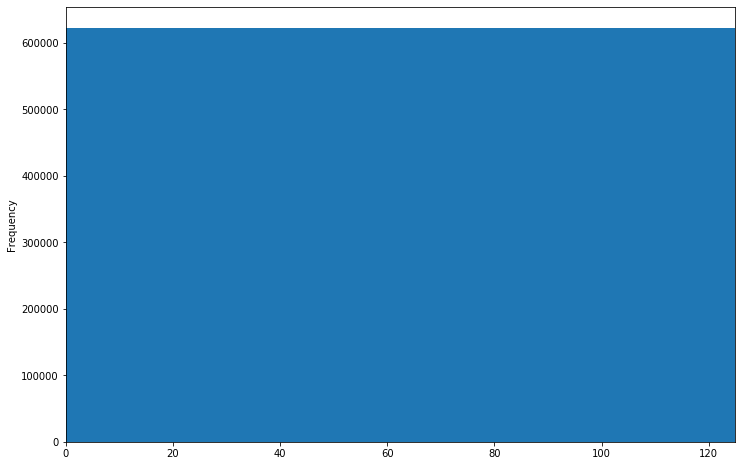

In [322]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
data2.close_big_city_dist.plot.hist(ax = ax, bins = 70)
plt.xlim(0,125)
plt.show()

In [19]:
# Load libraries and set up default values
from sklearn import (model_selection, preprocessing, linear_model, naive_bayes
                     , metrics)

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn import decomposition, ensemble


#import xgboost # A lot more optimized than sci-kit learn one
import string
import numpy as np
import pandas as pd
import scipy
import os
import io
#import aux_functions_mod  #Custom own functions

#### Num Ftrs

In [20]:
# Set Ftr Types
num_ftrs = list(data2.select_dtypes('number').columns)
num_ftrs.remove('valeur_fonciere')
num_ftrs 



['latitude',
 'longitude',
 'nombre_pieces_principales',
 'surface_reelle_bati',
 'surface_terrain']

#### Cat Ftrs

In [21]:
# let's capture the categorical variables first
cat_ftrs = [var for var in data2.columns if data2[var].dtype == 'O']
cat_ftrs

# Label encoder needs cat ftrs to be string.
for f in cat_ftrs:
    data2[f] = data2[f].astype(str)

### Separate dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set. This is to avoid over-fitting. There is an element of randomness in dividing the dataset, so remember to set the seed.

In [22]:
data2.loc[:,data2.columns[:-2]].columns
data2.columns

Index(['latitude', 'longitude', 'nombre_pieces_principales',
       'surface_reelle_bati', 'surface_terrain', 'type_local',
       'valeur_fonciere'],
      dtype='object')

In [23]:
# Let's separate into train and test set
# Remember to seet the seed (random_state for this sklearn function)
# 
X_train, X_test, y_train, y_test = train_test_split(data2.loc[:,data2.columns[:-1]], data2.valeur_fonciere,
                                                    test_size=0.1,
                                                    random_state=SEED) # we are setting the seed here
X_train.shape, X_test.shape
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 566427 entries, 510716 to 277885
Data columns (total 6 columns):
latitude                     566427 non-null float64
longitude                    566427 non-null float64
nombre_pieces_principales    566427 non-null float64
surface_reelle_bati          566427 non-null float64
surface_terrain              566427 non-null float64
type_local                   566427 non-null object
dtypes: float64(5), object(1)
memory usage: 30.3+ MB


In [ ]:
from catboost import CatBoostRegressor

In [31]:
!pip install lightgbm

In [34]:
# =======================Training Pipeline=================================
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from tempfile import mkdtemp
from joblib import Memory
from sklearn.feature_selection import chi2, SelectPercentile #SelectFromModel
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
#from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor



FIX_RAND_STATE = SEED

# Set temp storage to cache first pipe transformations
#cachedir = mkdtemp()
#memory = Memory(location=cachedir, verbose=0)


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
cached_pipe = Pipeline(steps=[('preprocessor', preprocessor)
                      ,#('classifier', LogisticRegression())
                             ])



## Delete the temporary cache
#before exiting
#from shutil import rmtree
#rmtree(cachedir)


params_grid = {

               #, 'ftr_select_percent__percentile': [5,10,20,50] #, 10, 20, 40Retain nth perc
               #, 'feature_select__threshold': [.05, .1] # Drops features with weights under threshold
             }


# Set models and hyperparameters
models = [
          #  ('nb', naive_bayes.MultinomialNB())
           ('lasso', linear_model.Ridge( random_state=FIX_RAND_STATE))
          #, ('knn',  KNeighborsRegressor())                                     
          #,('tree', DecisionTreeRegressor( random_state=FIX_RAND_STATE))
          # ,('rf', RandomForestRegressor( random_state=FIX_RAND_STATE )) #random_state=FIX_RAND_STATE
          #, ('sk_xgb', ensemble.GradientBoostingClassifier(random_state=FIX_RAND_STATE))
          #, ('xgb', xgboost.XGBClassifier(random_state=FIX_RAND_STATE))
           #('catgb'. CatBoostRegressor())
          , ('lgbmr', LGBMRegressor())
          ]

modelsDic = dict(models)


model_params = {
              #   'knn__n_neighbors': [5]
               'lasso__alpha': [1] #.001,.01, .1, 1, 10, 100, 1000, 10000, 100000
              #, 'tree__max_features':['sqrt']
              #,  'lasso__penalty':['l2'] #'l1',
              #, 'svm__C': [1] #.001,.01, .1, 1, 10, 100, 1000, 10000, 100000
              #, 'svm__kernel':  ['linear', 'rbf']
              # ,'rf__max_features':['sqrt'] #, 'log2', 'auto'
              # , 'catgb__n?estimators' : [100]
              #, 'rf__n_estimators': [1000]
              #, 'sk_xgb__max_depth':[2,3]
              #, 'sk_xgb__subsample': [1.0]
              #, 'sk_xgb__max_features':['auto', 'sqrt', 'log2']
              #, 'sk_xgb__n_estimators':[500]
              #, 'xgb__learning_rate':[0.01]
              #, 'xgb__max_depth':[3] #2,3,4
              #, 'xgb__colsample_bytree':[.7] #
              #, 'xgb__subsample': [.8]
              #, 'xgb__objective': ['binary:logistic']
              #, 'xgb__gamma':[1]
              #, 'xgb__n_estimators': [1000]
               ,'lgbmr__n_estimators':[100] #, 'log2', 'auto'    
        }


preproc_hparams_count = np.prod([len(params_grid[k]) for k in params_grid.keys()])
model_params_count = np.prod([len(model_params[k]) for k in model_params.keys()])
combinations = preproc_hparams_count * model_params_count
print('Total grid search space size: %.d combinations to test'% ( combinations) )

scores = {}
ftr_compress = False
folds = 3


 
import time #Measure gridSearchCV execution time
start = time.time()
print(modelsDic.keys())
for model_name in list(modelsDic.keys()):
    print('Training model %s ...' % model_name)
    pipe = cached_pipe
    pipe.steps.append((model_name, modelsDic[model_name]))
    
    #Add only model_name parameters to the grid dict
    filtered_params = params_grid.copy() #Initialize with preprocess variations to test
    for key in model_params.keys():
        if model_name in key:
            filtered_params[key]=model_params[key]
            
    cv_splitter = model_selection.KFold(n_splits=folds
                                  , random_state=FIX_RAND_STATE)
    
    scorer = metrics.make_scorer(metrics.mean_squared_error)#, average = score_avg
    performance_metric_name = scorer.__str__().rstrip(')').split('(')[1] # Extract scorer metric name

    
    gs = model_selection.GridSearchCV(estimator=pipe, param_grid = filtered_params
                                  , cv = cv_splitter, n_jobs=-1,  scoring = scorer )
    print(filtered_params)
    
    gs.fit(X_train, np.log1p(y_train))
    scores[model_name] = None
    scores[model_name]={'best_score':  gs.best_score_}
    print("Best {}: {:.4f} with params: {}: ".format( performance_metric_name
                                          , gs.best_score_, gs.best_params_))
    
    pipe.steps.pop()   #Pop model in turn from pipe

    # Store best model results to plot i.e  those corresponding to best model params
    cv_results_df = pd.DataFrame(gs.cv_results_)
    # Get the best candidate parameter setting.
    scores[model_name]['cv_optim_result'] = cv_results_df.loc[gs.best_index_,:]
    scores[model_name]['best_estimator'] = gs.best_estimator_
        
end = time.time()
total_elapsed_seconds = end - start
print('Grid search elapsed time: %.2f minutes'% (total_elapsed_seconds/60))



Total grid search space size: 1 combinations to test
dict_keys(['lasso', 'lgbmr'])
Training model lasso ...
{'lasso__alpha': [1]}
Best mean_squared_error: 0.7499 with params: {'lasso__alpha': 1}: 
Training model lgbmr ...
{'lgbmr__n_estimators': [100]}
Best mean_squared_error: 0.4406 with params: {'lgbmr__n_estimators': 100}: 
Grid search elapsed time: 0.98 minutes


In [70]:
first_model = list(scores.keys())[0] # Just to get columns of results summary

results_pd = pd.DataFrame(None, columns = ['model'] + list(scores[first_model]['cv_optim_result'].index))
results_pd

,model,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score


In [99]:
models_performance = [(k,scores[k]['best_score']) for k in scores.keys()]
best_model = sorted(models_performance, key=lambda x: x[1], reverse=False)[0][0]
best_model

'lgbmr'

In [102]:
scores[best_model]['best_estimator'][-1]

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
scores.

In [103]:
y_pred = np.expm1(scores[best_model]['best_estimator'].predict(X_test))
print(list(zip(y_test,y_pred))[0:10])



[(235000.0, 191964.15914295975), (105400.0, 116464.63700847368), (86000.0, 170568.6660852802), (35000.0, 56446.99604979182), (181000.0, 197161.3138493486), (61000.0, 59503.20563856964), (57300.0, 83417.26473333043), (91000.0, 83728.69597149626), (71500.0, 72548.45868753687), (25000.0, 70899.02731746994)]


In [104]:
# Base estimator is the overall mean
m = y_test.median()
y_pred =[m for m in range(len(y_test))]

performance = np.sqrt(mean_squared_error(y_test, y_pred))
print('Base model performance: {:.2f} '.format(performance))

Base model performance: 1953984.75 


In [108]:
y_pred = np.expm1(scores[best_model]['best_estimator'].predict(X_test))

performance = np.sqrt(mean_squared_error(y_test, y_pred))
print('Base model performance: {:.2f}'.format(performance))

Base model performance: 1767979.84


In [138]:
from joblib import dump, load

dump(scores[best_model][ 'best_estimator'], '../../models/model.joblib') 
clf3 = load('../../models/model.joblib') 
new_vals = X_test[0:2]
new_preds = np.expm1(clf3.predict(new_val))
print(new_preds)
y_test[0:2]


[191964.15914296 116464.63700847]


93330    235000.0
29290    105400.0
Name: valeur_fonciere, dtype: float64

### Export first test data as example for frontend app

In [143]:

X_test.tail(1).to_csv('../../data/ui/input_data_sample.csv', index=False)

X_test.tail(1)

,latitude,longitude,nombre_pieces_principales,surface_reelle_bati,surface_terrain,type_local
134133,43.822579,4.362797,2.0,50.0,0.0,Appartement
